### 1. Importing dependencies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgbcv_pipe_configs import Config
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.inspection import permutation_importance, partial_dependence, PartialDependenceDisplay
import pickle

### 2. Reading both training and test sets and preprocessing

In [2]:
train_df = pd.read_csv("../../datasets/classification_data/classification_train.csv")
test_df  = pd.read_csv("../../datasets/classification_data/classification_test.csv")

Throughout this modeling, it was considered feature construction in order to address underfitting from the model used. With these extra features, it was possible to add 1% in the evaluation metric after model fine tuning.

In [3]:
train_df['x3'] = (train_df.x1 ** 2) * (train_df.x2 ** 4)
test_df['x3'] = (test_df.x1 ** 2) * (test_df.x2 ** 4)

train_df['x4'] = (np.sqrt(abs(train_df.x1))) + (train_df.x2 ** 3)
test_df['x4'] = (np.sqrt(abs(test_df.x1))) + (test_df.x2 ** 3)

In [5]:
train_df.shape

(670, 5)

Compact dataset with only two predictive features. The dataset is well-balanced as the target feature states when counting labels for the binary class.

In [6]:
train_df.target.value_counts()

1    339
0    331
Name: target, dtype: int64

In [7]:
test_df.target.value_counts()

0    169
1    161
Name: target, dtype: int64

In [8]:
train_df.sample(5)

,x1,x2,target,x3,x4
346,1.817807,-0.397914,1,0.082842,1.285257
36,0.859536,1.034466,0,0.846045,2.034115
467,0.980698,0.235126,0,0.002939,1.003300
82,0.691932,0.628511,0,0.074710,1.080103
49,2.093685,0.437280,1,0.160273,1.530571


No null values and the dtype of all features are numbers so we can proceed to define the pipeline.

In [9]:
train_df.isnull().sum()

x1        0
x2        0
target    0
x3        0
x4        0
dtype: int64

In [10]:
test_df.isnull().sum()

x1        0
x2        0
target    0
x3        0
x4        0
dtype: int64

In [11]:
train_df.dtypes

x1        float64
x2        float64
target      int64
x3        float64
x4        float64
dtype: object

Just a simple visualization to understand the distributions of the features and how we can relate them to targeting the classes.
As we look through the <strong>x1</strong> axes and fix a point in the <strong>x2</strong> axes, we can have a first impression over the lower predictive power of <strong>x1</strong> for targeting the classes when compared to <strong>x2</strong>. The <strong>x2</strong> feature defines a more evident decision boundary through its range of values. 

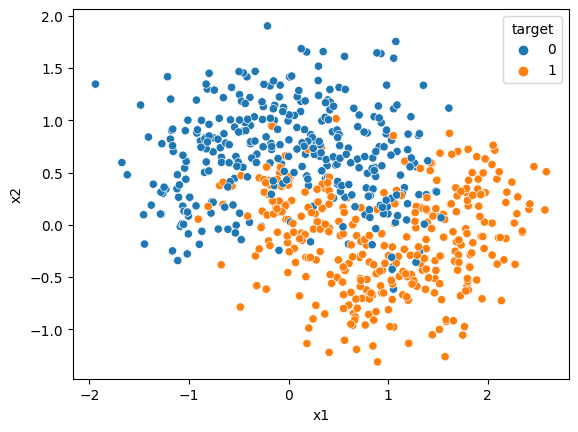

In [12]:
sns.scatterplot(data=train_df, x='x1', y='x2', hue='target')
plt.show()

#### 2.1 Split both train and test sets into predictive features and target labels

In [13]:
y_train = train_df.target
X_train = train_df.drop(columns=['target'])

y_test = test_df.target
X_test = test_df.drop(columns=['target'])

#### 2.2 Using LocalOutlierFactor in order to detect possible outliers that could harm model prediction

This is an unsupervised algorithm that defines local densities for each sample and decides whether a specific one is an outlier based on neighbors densities (samples that have a substantially lower density than their neighbors are considered outliers).

In [14]:
X_train_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X_train))
X_train_scaled.columns = ['x1', 'x2', 'x3', 'x4']

In [15]:
lof = LocalOutlierFactor(n_neighbors=20).fit(X_train_scaled)

The 14 outliers detected are marked as -1 and further not considered for training the classifier.

In [16]:
outliers_preds = lof.fit_predict(X_train_scaled)
pd.DataFrame(outliers_preds).value_counts()

 1    638
-1     32
dtype: int64

In [17]:
X_train = X_train[outliers_preds == 1]
y_train = y_train[outliers_preds == 1]

In [18]:
X_train.shape

(638, 4)

### 3. Training the classifier: GradientBoostingClassifier

#### 3.1 Defining the pipeline

Using pipelines, we can automate some tasks as scaling and dtype transformation. In this case, we only need to take care of feature scaling. The estimator is first defaultly defined so that we can fine tune later.

In [19]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('estimator', GradientBoostingClassifier(random_state=42))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator', GradientBoostingClassifier(random_state=42))])

Gathering the metrics for the default model to further evaluation and discussion.

In [20]:
y_pred_train = pipe.predict(X_train)

train_metrics = {'values': [f1_score(y_pred_train, y_train),
                      recall_score(y_pred_train, y_train),
                      precision_score(y_pred_train, y_train)],
           'scorer': ['f1', 'recall', 'precision'],
           'estimator': 'default',
           'dataset': 'train'}

In [21]:
y_pred_test = pipe.predict(X_test)

test_metrics = {'values': [f1_score(y_pred_test, y_test),
                      recall_score(y_pred_test, y_test),
                      precision_score(y_pred_test, y_test)],
           'scorer': ['f1', 'recall', 'precision'],
           'estimator': 'default',
           'dataset': 'test'}

#### 3.2 Fine tuning: evaluation metric defined as F1 score

This code below was iteratively executed for each of these hyperparameter from the GradientBoostingClassifier. The idea was to fit the model considering a variety of values for one single parameter and to choose the one value that best fits the model in terms of denying both under and overfitting. Then, this value was fixed and the next hyperparameter would be tuned.

This is the last step of this algorithm, where <strong>max_features, min_samples_leaf, max_depth</strong> and <strong>n_estimators</strong> have already been tuned and their best values fixed in order to choose now the best one for <strong>min_samples_split</strong>.

From the graph, we can see that there is a point from <strong>min_samples_split</strong> where the F1 score for test set is maximum, but through the values of this hyperparemeter the training set decreases. This is not ideal, we would like to keep the score for the training fixed and only increase the one for test set. 

This is similar to what GridSearchCV does, but instead of testing all possibilities we address the ones we define as best.

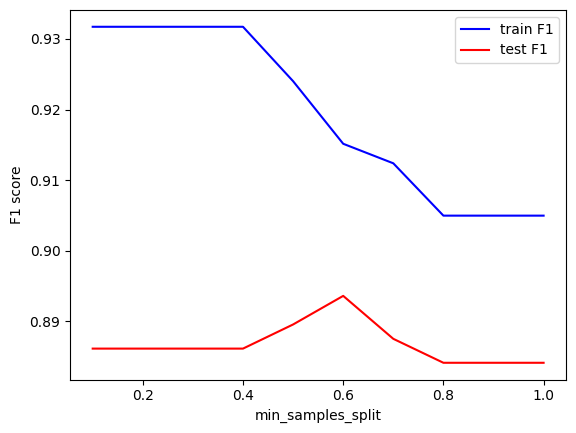

In [22]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for i in min_samples_splits:
    pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('estimator', GradientBoostingClassifier(min_samples_split=i, max_features=2, min_samples_leaf=.2, max_depth=5, n_estimators=200, random_state=6, learning_rate=.2))
    ])
    
    pipe.fit(X_train, y_train)
    
    train_results.append(f1_score(pipe.predict(X_train), y_train))
    test_results.append(f1_score(pipe.predict(X_test), y_test))

plt.xlabel('min_samples_split')
plt.ylabel('F1 score')
plt.plot(min_samples_splits, train_results, 'b', label='train F1')
plt.plot(min_samples_splits, test_results, 'r', label='test F1')
plt.legend()
plt.show()

Therefore, according to this fine tuning, the best model that fits the dataset is described in the pipeline below.

In [23]:
best_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('estimator', GradientBoostingClassifier(min_samples_split=.6,
                                             max_features=2,
                                             min_samples_leaf=.2,
                                             max_depth=5,
                                             n_estimators=200,
                                             learning_rate=.2,
                                             random_state=6))
]).fit(X_train, y_train)

This is the F1 score this model defines for test set.

In [24]:
f1_score(best_pipe.predict(X_test), y_test)

0.8936170212765957

#### 3.3 Trying GridSearchCV

Let's see whether GridSearchCV can find better hyperparameters configurations in order to increase F1 score from the previous model we have stated.

Instantiating the GridSearchCV configuration class.

In [25]:
configs = Config()

Defining the GridSearchCV over the pipeline previously stated. The parameters from the GradientBoostingClassifier to be fine tuned are defined in 'xgbcv_pipe_configs', as well as the scores. The refitting is called so that the 'f1_score', adopted as evaluation metric, is considered primordial when fitting the 5 folds for each candidate estimator in the search.

In [26]:
xgb_gscv = GridSearchCV(estimator=pipe, param_grid=configs.params, verbose=True, scoring=configs.scores, refit='f1').fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [27]:
xgb_gscv.best_params_

{'estimator__learning_rate': 0.1,
 'estimator__max_depth': 4,
 'estimator__max_features': 4,
 'estimator__min_samples_leaf': 0.1,
 'estimator__min_samples_split': 0.7,
 'estimator__n_estimators': 200}

In [28]:
xgb_pipe = xgb_gscv.best_estimator_

In [29]:
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('estimator',
                 GradientBoostingClassifier(max_depth=4, max_features=4,
                                            min_samples_leaf=0.1,
                                            min_samples_split=0.7,
                                            n_estimators=200,
                                            random_state=6))])

It is pretty close from what we have found earlier with the manual tuning, but it is still not better.

In [30]:
f1_score(xgb_pipe.predict(X_test), y_test)

0.8895705521472393

#### 3.4 Showing the results

This model considers the F1 score as evaluation metric and both precision and recall as satisficing ones. Once F1 score is defined using these two satisficing metrics, in order to consider in this case the model good, precision and recall should both be above 85%. This should state that the resulting F1 score reflects well the predictive power of the model.

In [31]:
y_pred_test = best_pipe.predict(X_test)

test_metrics_ft = {'values': [f1_score(y_pred_test, y_test),
                            recall_score(y_pred_test, y_test),
                            precision_score(y_pred_test, y_test)],
                 'scorer': ['f1', 'recall', 'precision'],
                 'estimator': 'fine-tuned',
                 'dataset': 'test'}

In [32]:
y_pred_train = best_pipe.predict(X_train)

train_metrics_ft = {'values': [f1_score(y_pred_train, y_train),
                               recall_score(y_pred_train, y_train),
                               precision_score(y_pred_train, y_train)],
                 'scorer': ['f1', 'recall', 'precision'],
                 'estimator': 'fine-tuned',
                 'dataset': 'train'}

In [33]:
metrics = pd.concat([pd.DataFrame(train_metrics_ft), pd.DataFrame(test_metrics_ft), pd.DataFrame(train_metrics), pd.DataFrame(test_metrics)])

In [34]:
metrics.sort_values(by=['scorer', 'estimator'], ascending=True)

,values,scorer,estimator,dataset
0,0.958140,f1,default,train
0,0.874618,f1,default,test
0,0.915152,f1,fine-tuned,train
0,0.893617,f1,fine-tuned,test
2,0.950769,precision,default,train
2,0.888199,precision,default,test
2,0.929231,precision,fine-tuned,train
2,0.913043,precision,fine-tuned,test
1,0.965625,recall,default,train
1,0.861446,recall,default,test


The results show us that in the default model, overfitting was indeed a problem once the scores for training were too high compared to the ones for test set. But with the fine tuned model, this problem is reduced significantly. As for the evaluation metric, F1 score, the gap goes from 8% approximately to only 2%. 

But this shows another problem as the fine tuned model quite underfits the data. We know that it can perform better on the training set. One of the alternatives I tried was to use feature construction in order to gain more predictive power on the features, but perhaps the best solution is to collect more data for the model to learn from. As we have originally only two predictive features, the data could be considered small in order to address both underfitting and overfitting.

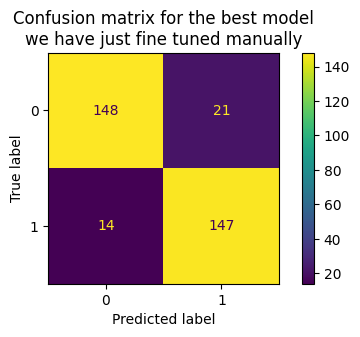

In [35]:
fig, ax = plt.subplots(figsize=(6,3))
cm = confusion_matrix(y_test, best_pipe.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipe.classes_).plot(ax=ax)
plt.title("Confusion matrix for the best model\nwe have just fine tuned manually")
plt.show()

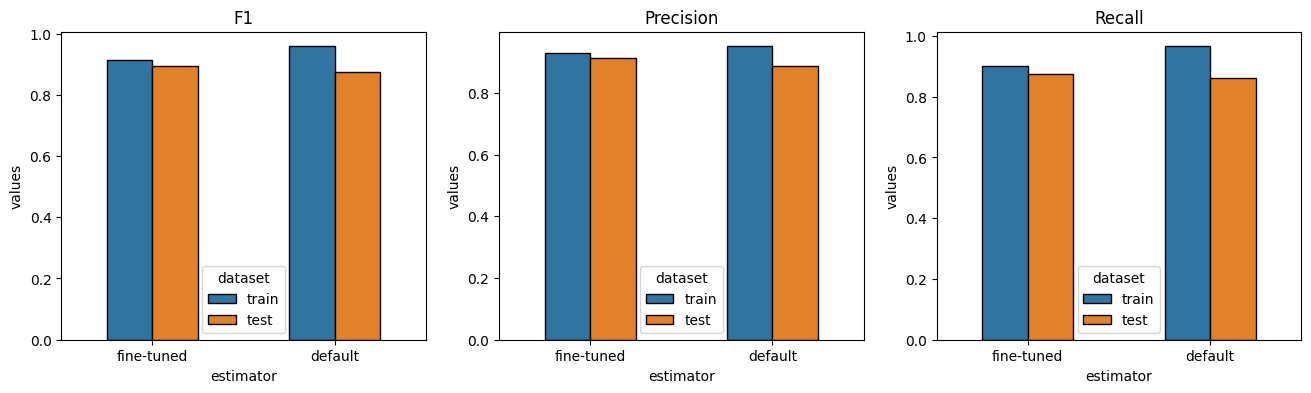

In [36]:
fig, ax = plt.subplots(ncols=3, figsize=(16,4))

sns.barplot(data=metrics[metrics.scorer == 'f1'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[0])
sns.barplot(data=metrics[metrics.scorer == 'precision'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[1])
sns.barplot(data=metrics[metrics.scorer == 'recall'], x='estimator', y='values', hue='dataset', width=.5, edgecolor='black', ax=ax[2])

ax[0].set_title("F1")
ax[1].set_title("Precision")
ax[2].set_title("Recall")
plt.show()

### 4. Analysing features importances and predictive power

#### 4.1 Permutation importance

This algorithm from scikit-learn compares the scores from permutating the features columns in comparison to some baseline metric.

After executing it, the mean values for the 'importance' of the features in terms of prediction is defined.

In [37]:
features_importances = permutation_importance(best_pipe, X_train, y_train, scoring='f1', n_repeats=10, random_state=42)

These results point to <strong>x2</strong> and <strong>x1</strong> as the variables with more predictive power over the target. Indeed, they are the original variables and the new ones should not have more predictive power than these original two.

In [38]:
features_importances.importances_mean

array([0.20117474, 0.20298998, 0.01191778, 0.13318811])

#### 4.3 Correlation over the training dataset

Understanding this heatmap also confirms previous analysis. <strong>x2</strong> and <strong>x1</strong> are the ones with the highest correlation with the target feature, meaning these two features are strongly related to target. Here, target and <strong>x2</strong> correlation should be highlighted. 

<Axes: >

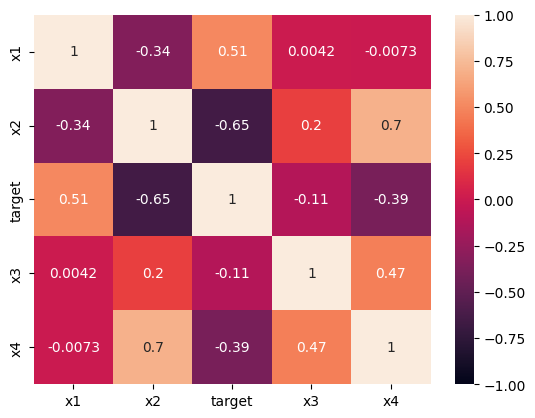

In [39]:
sns.heatmap(train_df.corr(), annot=True, vmin=-1, vmax=1)

#### 4.2 Using Partial Dependency Analysis

This technique defines the average response of the regressor estimator for each possible value from each feature in the set of predictive ones.

These results show that the regressor has indeed more partial dependence in <strong>x2</strong> compared to the others. We can see this as we go through the values for this features, the average response of the regressor increases more significantly. But it is interesting to see how the model has poor dependency over <strong>x1</strong> even it being originally defined in the dataset. Perhaps, the lack of predictive influence of <strong>x1</strong> reflects in the early underfitting problem stated previously.

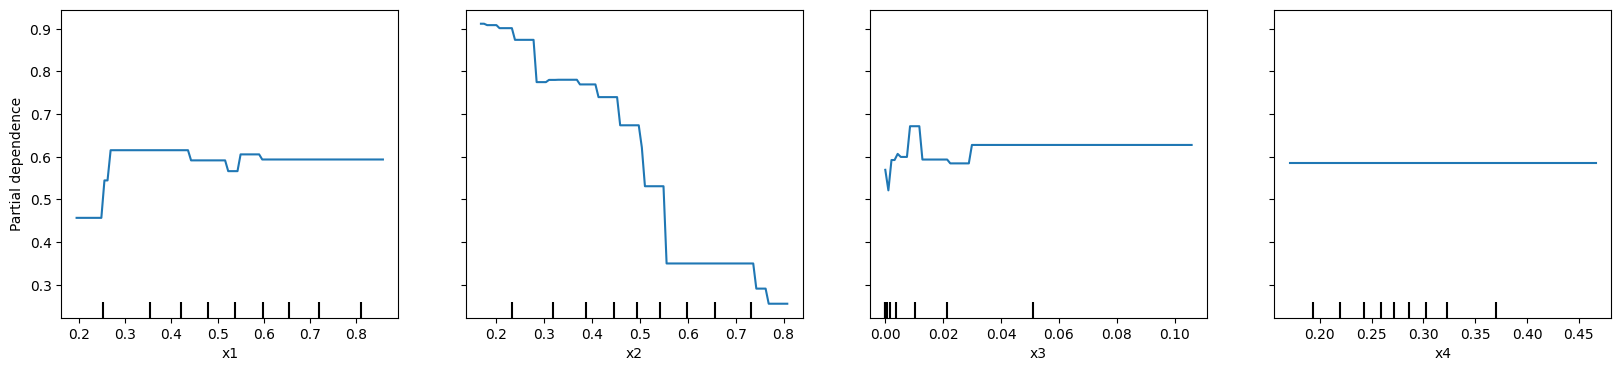

In [40]:
fig, ax = plt.subplots(figsize=(20,4))
PartialDependenceDisplay.from_estimator(best_pipe, X_train_scaled, ['x1', 'x2', 'x3', 'x4'], n_cols=7, ax=ax)

### 5. Dumping the model so that it can be loaded from the API builded

In [42]:
pickle.dump(best_pipe, open('../../models/classifier.pkl', 'wb'))